In [1]:
# loading libraries
import igor.igorpy as igor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [100]:
#load excel file
waveInfo = pd.read_excel('2016.10.19_Cell1.xlsx')
waveInfo.index = list(range(12, 82, 1))
waveInfo.tail()

,waveNum,waveName,stimInt,notes
77,66,w77,600.0,y
78,67,w78,800.0,y
79,68,w79,800.0,y
80,69,w80,1000.0,y
81,70,w81,1000.0,y


In [105]:
rawData = igor.load('2016.10.19_YW')
date = '2016.10.19'
cellNum = 1
age = 15

In [136]:
type(rawData)
igor.Folder.format(rawData)
rawData.children

 <igor.Wave peak1 data (1000)>,
 <igor.Wave series1 data (1000)>,
 <igor.Wave peak2 data (1000)>,
 <igor.Wave leak1 data (1000)>,
 <igor.Wave peak3 data (1000)>,
 <igor.Wave trial data (11573)>,
 <igor.Wave w1 data (1950)>,
 <igor.Wave w2 data (1950)>,
 <igor.Wave w3 data (25050)>,
 <igor.Wave w4 data (11563)>,
 <igor.Wave w5 data (11563)>,
 <igor.Wave w6 data (11563)>,
 <igor.Wave w7 data (11563)>,
 <igor.Wave w8 data (11563)>,
 <igor.Wave w9 data (11573)>,
 <igor.Wave w10 data (11563)>,
 <igor.Wave w11 data (11573)>,
 <igor.Wave w12 data (11563)>,
 <igor.Wave w13 data (11573)>,
 <igor.Wave w14 data (11563)>,
 <igor.Wave w15 data (11573)>,
 <igor.Wave w16 data (11563)>,
 <igor.Wave w17 data (11573)>,
 <igor.Wave w18 data (11563)>,
 <igor.Wave w19 data (11573)>,
 <igor.Wave w20 data (34074)>,
 <igor.Wave w21 data (54073)>,
 <igor.Wave w22 data (11563)>,
 <igor.Wave w23 data (11573)>,
 <igor.Wave w24 data (11563)>,
 <igor.Wave w25 data (11573)>,
 <igor.Wave w26 data (11563)>,
 <igor.Wav

In [116]:
#write function to do this automatically for all waves in rawData
#Store output in pd data frame
someWave = rawData.w70
time = someWave.axis[0][::-1] # pull time data and reverse it
current = someWave.data
wave = np.column_stack((time, current))
pd_w70 = pd.DataFrame(wave)
pd_w70.columns = ['sec', 'pA']

#may not be necessary in fxn
w70_info = waveInfo.loc[[70], :]
#print(w70_info)
#split data based on times
for trace in rawData :
    someTrace = rawData.trace
    current = someTrace.data
    wave = pd.DataFrame(np.column_stack(time, current))
    wave.columns = ['sec', 'pA']
    print(wave)

AttributeError: 'Folder' object has no attribute 'trace'

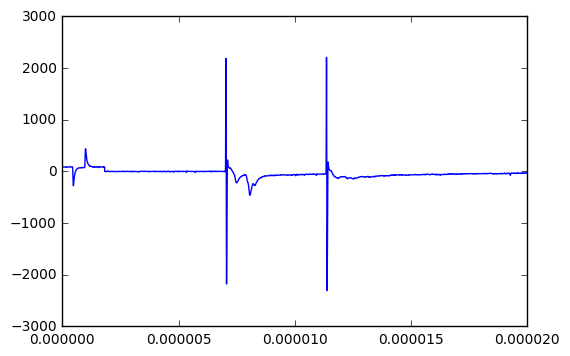

In [80]:
plt.plot(pd_wave['sec'], pd_wave['pA'])
plt.show()